In [1]:
from __future__ import absolute_import, division, print_function

import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json

from utils import *
from kitti_utils import *
from layers import *
from Encoder import *
from depthDecoder import *

import datasets
import networks
from IPython import embed
cuda = torch.cuda.is_available()
cuda

True

In [2]:
dataset = datasets.KITTIRAWDataset 
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_zhou/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_zhou/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [3]:
height = 192
width = 640
scales = np.arange(4)
img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")
#device = torch.device("cpu")
frame_ids = [0,'s']
weights_init = 'pretrained'
num_scales = len(scales)
num_input_frames = len(frame_ids)
num_layers = 18
learning_rate = 0.0001

In [4]:
batch_size = 32
num_workers = 12

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [6]:
params = []
encoder = networks.ResnetEncoder(num_layers,False ) #weights_init == "pretrained"
#encoder = ResnetEncoder()
#encoder.apply(init_weights)
params += list(encoder.parameters())

decoder = networks.DepthDecoder(encoder.num_ch_enc, scales)
#decoder = Decoder(encoder.num_ch_enc, scales)
#decoder.apply(init_weights)
params += list(decoder.parameters())
ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
optimizer = optim.Adam(params, learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

In [5]:
models = {}
parameters_to_train = []

device = torch.device("cuda" if cuda else "cpu")

models["encoder"] = networks.ResnetEncoder(num_layers, False)
models["encoder"].to(device)
parameters_to_train += list(models["encoder"].parameters())

models["depth"] = networks.DepthDecoder(models["encoder"].num_ch_enc, scales)
models["depth"].to(device)
parameters_to_train += list(models["depth"].parameters())

ssim = SSIM()
ssim.to(device)
optimizer = optim.Adam(parameters_to_train, learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

In [6]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

There are 39810 training items and 4424 validation items



In [7]:
def generate_images_pred(inputs, outputs):

    for scale in scales:
        disp = outputs[("disp", scale)]


        disp = F.interpolate(
                disp, [height, width], mode="bilinear", align_corners=False)
        source_scale = 0

        _, depth = disp_to_depth(disp, 0.1, 100)

        outputs[("depth", 0, scale)] = depth

        for i, frame_id in enumerate(frame_ids[1:]):

            if frame_id == "s":
                T = inputs["stereo_T"]
            else:
                T = outputs[("cam_T_cam", 0, frame_id)]


            cam_points = backproject_depth[source_scale](
                depth, inputs[("inv_K", source_scale)])
            pix_coords = project_3d[source_scale](
                cam_points, inputs[("K", source_scale)], T)

            outputs[("sample", frame_id, scale)] = pix_coords

            outputs[("color", frame_id, scale)] = F.grid_sample(
                inputs[("color", frame_id, source_scale)],
                outputs[("sample", frame_id, scale)],
                padding_mode="border")

            outputs[("color_identity", frame_id, scale)] = inputs[("color", frame_id, source_scale)]

    return outputs

In [8]:
def compute_reprojection_loss(pred, target):

        abs_diff = torch.abs(target - pred)
        l1_loss = abs_diff.mean(1, True)

        ssim_loss = ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

In [9]:

    def compute_losses(self, inputs, outputs):
        """Compute the reprojection and smoothness losses for a minibatch
        """
        losses = {}
        total_loss = 0

        for scale in self.opt.scales:
            loss = 0
            reprojection_losses = []

            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in self.opt.frame_ids[1:]:
                #print('frame_id loss',frame_id)
                pred = outputs[("color", frame_id, scale)]
                reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            #print(' reprojection_losses shape',reprojection_losses.shape)

            if not self.opt.disable_automasking:
                
                identity_reprojection_losses = []
                for frame_id in self.opt.frame_ids[1:]:
                    pred = inputs[("color", frame_id, source_scale)]
                    identity_reprojection_losses.append(
                        self.compute_reprojection_loss(pred, target))

                identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)

                if self.opt.avg_reprojection:
                    identity_reprojection_loss = identity_reprojection_losses.mean(1, keepdim=True)
                else:
                    # save both images, and do min all at once below
                    identity_reprojection_loss = identity_reprojection_losses

            elif self.opt.predictive_mask:
                # use the predicted mask
                mask = outputs["predictive_mask"]["disp", scale]
                if not self.opt.v1_multiscale:
                    mask = F.interpolate(
                        mask, [self.opt.height, self.opt.width],
                        mode="bilinear", align_corners=False)

                reprojection_losses *= mask

                # add a loss pushing mask to 1 (using nn.BCELoss for stability)
                weighting_loss = 0.2 * nn.BCELoss()(mask, torch.ones(mask.shape).cuda())
                loss += weighting_loss.mean()

            if self.opt.avg_reprojection:
                reprojection_loss = reprojection_losses.mean(1, keepdim=True)
            else:
              
                reprojection_loss = reprojection_losses

            if not self.opt.disable_automasking:
                # add random numbers to break ties
         
                identity_reprojection_loss += torch.randn(
                    identity_reprojection_loss.shape).cuda() * 0.00001

                combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)
            else:
                combined = reprojection_loss

            if combined.shape[1] == 1:
       
                to_optimise = combined
            else:
             
                to_optimise, idxs = torch.min(combined, dim=1)

            if not self.opt.disable_automasking:
       
                outputs["identity_selection/{}".format(scale)] = (
                    idxs > identity_reprojection_loss.shape[1] - 1).float()

            loss += to_optimise.mean()

            mean_disp = disp.mean(2, True).mean(3, True)
            norm_disp = disp / (mean_disp + 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss += self.opt.disparity_smoothness * smooth_loss / (2 ** scale)
            total_loss += loss
            losses["loss/{}".format(scale)] = loss

        total_loss /= self.num_scales
        losses["loss"] = total_loss
        return losses

In [10]:
def compute_depth_losses(inputs, outputs, losses):
 
        pred = outputs[("depth", 0, 0)]
        pred = torch.clamp(F.interpolate(pred, [375, 1242], mode="bilinear", align_corners=False), 1e-3, 80)
        pred = pred.detach()

        gt = inputs["depth_gt"]
        mask = gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = gt[mask]
        pred = pred[mask]
        pred *= torch.median(gt) / torch.median(pred)

        pred = torch.clamp(pred, min=1e-3, max=80)

        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = (gt - pred) ** 2
        rmse = torch.sqrt(rmse.mean())

        rmse_log = (torch.log(gt) - torch.log(pred)) ** 2
        rmse_log = torch.sqrt(rmse_log.mean())

        abs_rel = torch.mean(torch.abs(gt - pred) / gt)

        sq_rel = torch.mean((gt - pred) ** 2 / gt)

        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])

In [11]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        models["encoder"].train()
        models["depth"].train()
        for epoch in range(num_epochs):

            total_loss = 0 
            #lr_scheduler.step()
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):
                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = models["encoder"](inputs["color_aug", 0, 0])
                outputs = models["depth"](features)
       
                outputs1 = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, outputs1)
                total_loss = total_loss + losses['loss'].item()

                losses["loss"].backward()
                optimizer.step()
                

                del inputs, outputs, losses,features
                if batch_idx%100==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    print('Loss: ',total_loss/(batch_idx+1))
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            #validation(encoder,decoder,val_loader)

In [15]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [28]:
num_epochs = 1
train(encoder,decoder,train_loader,val_loader,num_epochs)

Training Epoch:   0%|          | 1/1244 [00:28<9:40:42, 28.03s/it]/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Training Epoch:   8%|▊         | 102/1244 [03:34<35:05,  1.84s/it] 

Batch No:  100
Loss:  0.17703494931211566


Training Epoch:  16%|█▌        | 202/1244 [06:43<28:06,  1.62s/it]  

Batch No:  200
Loss:  0.1665947549971775


Training Epoch:  23%|██▎       | 289/1244 [09:21<26:49,  1.69s/it]

KeyboardInterrupt: 

In [12]:
num_epochs = 1
train(models["encoder"],models["depth"],val_loader,val_loader,num_epochs)

Training Epoch:   1%|          | 1/138 [00:18<43:04, 18.87s/it]/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Training Epoch:  74%|███████▍  | 102/138 [02:25<00:44,  1.25s/it]

Batch No:  100
Loss:  0.17531897821048698


Training Epoch: 100%|██████████| 138/138 [03:06<00:00,  1.07s/it]

Train Loss at Epoch_1: 0.16982651167157767


In [15]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
width = 640
height =192
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [17]:
Trainer.parameters_to_train

AttributeError: type object 'Trainer' has no attribute 'parameters_to_train'

In [19]:

device = torch.device("cuda" if cuda else "cpu")
with torch.no_grad():
    trainer.models["encoder"].eval()
    trainer.models["depth"].eval()
    features = trainer.models["encoder"](input_image_pytorch.to(device))
    outputs = trainer.models["depth"](features)

disp = outputs[("disp", 0)]

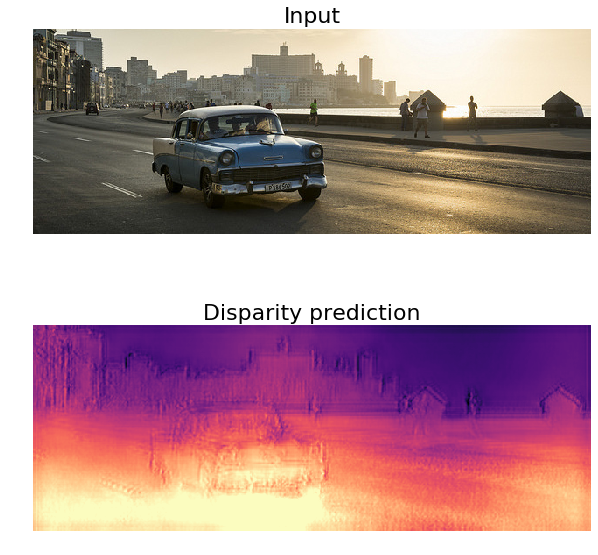

In [20]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [21]:
disp.max()

tensor(0.3591, device='cuda:0')

In [10]:
# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

import json

from utils import *
from kitti_utils import *
from layers import *

import datasets
import networks
from IPython import embed


class Trainer:
    def __init__(self, options):
        self.opt = options


        # checking height and width are multiples of 32
        assert self.opt.height % 32 == 0, "'height' must be a multiple of 32"
        assert self.opt.width % 32 == 0, "'width' must be a multiple of 32"

        self.models = {}
        self.parameters_to_train = []

        self.device = torch.device("cpu" if self.opt.no_cuda else "cuda")

        self.num_scales = len(self.opt.scales)
        self.num_input_frames = len(self.opt.frame_ids)
        self.num_pose_frames = 2 if self.opt.pose_model_input == "pairs" else self.num_input_frames

        assert self.opt.frame_ids[0] == 0, "frame_ids must start with 0"

        self.use_pose_net = not (self.opt.use_stereo and self.opt.frame_ids == [0])

        if self.opt.use_stereo:
            self.opt.frame_ids.append("s")

        self.models["encoder"] = networks.ResnetEncoder(
            self.opt.num_layers, self.opt.weights_init == "pretrained")
        self.models["encoder"].to(self.device)
        self.parameters_to_train += list(self.models["encoder"].parameters())

        self.models["depth"] = networks.DepthDecoder(
            self.models["encoder"].num_ch_enc, self.opt.scales)
        self.models["depth"].to(self.device)
        self.parameters_to_train += list(self.models["depth"].parameters())

        if self.use_pose_net:
            print('pose net')
            if self.opt.pose_model_type == "separate_resnet":
   
                self.models["pose_encoder"] = networks.ResnetEncoder(
                    self.opt.num_layers,
                    self.opt.weights_init == "pretrained",
                    num_input_images=self.num_pose_frames)

                self.models["pose_encoder"].to(self.device)
                self.parameters_to_train += list(self.models["pose_encoder"].parameters())

                self.models["pose"] = networks.PoseDecoder(
                    self.models["pose_encoder"].num_ch_enc,
                    num_input_features=1,
                    num_frames_to_predict_for=2)

            elif self.opt.pose_model_type == "shared":
                self.models["pose"] = networks.PoseDecoder(
                    self.models["encoder"].num_ch_enc, self.num_pose_frames)

            elif self.opt.pose_model_type == "posecnn":
                self.models["pose"] = networks.PoseCNN(
                    self.num_input_frames if self.opt.pose_model_input == "all" else 2)

            self.models["pose"].to(self.device)
            self.parameters_to_train += list(self.models["pose"].parameters())

        if self.opt.predictive_mask:
            print('predictive_mask')
            assert self.opt.disable_automasking, \
                "When using predictive_mask, please disable automasking with --disable_automasking"

            # Our implementation of the predictive masking baseline has the the same architecture
            # as our depth decoder. We predict a separate mask for each source frame.
            self.models["predictive_mask"] = networks.DepthDecoder(
                self.models["encoder"].num_ch_enc, self.opt.scales,
                num_output_channels=(len(self.opt.frame_ids) - 1))
            self.models["predictive_mask"].to(self.device)
            self.parameters_to_train += list(self.models["predictive_mask"].parameters())

        self.model_optimizer = optim.Adam(self.parameters_to_train, self.opt.learning_rate)
        self.model_lr_scheduler = optim.lr_scheduler.StepLR(
            self.model_optimizer, self.opt.scheduler_step_size, 0.1)

        if self.opt.load_weights_folder is not None:
            print('loading weight')
            self.load_model()

        print("Training model named:\n  ", self.opt.model_name)
       
        print("Training is using:\n  ", self.device)

        # data
        datasets_dict = {"kitti": datasets.KITTIRAWDataset,
                         "kitti_odom": datasets.KITTIOdomDataset}
        self.dataset = datasets_dict[self.opt.dataset]
        
        dataset = datasets.KITTIRAWDataset 
        data_path = "/home/ubuntu/monodepth2/kitti_data"
        fpath_train = "/home/ubuntu/monodepth2/splits/eigen_zhou/val_files.txt"
        f_train = open(fpath_train)
        train_filenames = f_train.readlines()
        fpath_val = "/home/ubuntu/monodepth2/splits/eigen_zhou/val_files.txt"
        f_val = open(fpath_val)
        val_filenames = f_val.readlines()

        #fpath = os.path.join(os.path.dirname(__file__), "splits", self.opt.split, "{}_files.txt")

        #train_filenames = readlines(fpath.format("val"))
        #val_filenames = readlines(fpath.format("val"))
        img_ext = '.png' if self.opt.png else '.jpg'

        num_train_samples = len(train_filenames)
        self.num_total_steps = num_train_samples // self.opt.batch_size * self.opt.num_epochs

        train_dataset = self.dataset(
            self.opt.data_path, train_filenames, self.opt.height, self.opt.width,
            self.opt.frame_ids, 4, is_train=True, img_ext=img_ext)
      
        self.train_loader = DataLoader(
            train_dataset, self.opt.batch_size, True,
            num_workers=self.opt.num_workers, pin_memory=True, drop_last=True)
        val_dataset = self.dataset(
            self.opt.data_path, val_filenames, self.opt.height, self.opt.width,
            self.opt.frame_ids, 4, is_train=False, img_ext=img_ext)
        self.val_loader = DataLoader(
            val_dataset, self.opt.batch_size, True,
            num_workers=self.opt.num_workers, pin_memory=True, drop_last=True)
        self.val_iter = iter(self.val_loader)



        if not self.opt.no_ssim:
            self.ssim = SSIM()
            self.ssim.to(self.device)

        self.backproject_depth = {}
        self.project_3d = {}
        for scale in self.opt.scales:
            h = self.opt.height // (2 ** scale)
            w = self.opt.width // (2 ** scale)

            self.backproject_depth[scale] = BackprojectDepth(self.opt.batch_size, h, w)
            self.backproject_depth[scale].to(self.device)

            self.project_3d[scale] = Project3D(self.opt.batch_size, h, w)
            self.project_3d[scale].to(self.device)

        self.depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]

        print("Using split:\n  ", self.opt.split)
        print("There are {:d} training items and {:d} validation items\n".format(
            len(train_dataset), len(val_dataset)))


    def set_train(self):
        """Convert all models to training mode
        """
        for m in self.models.values():
            m.train()

    def set_eval(self):
        """Convert all models to testing/evaluation mode
        """
        for m in self.models.values():
            m.eval()

    def train(self):
        """Run the entire training pipeline
        """
        self.epoch = 0
        self.step = 0
        self.start_time = time.time()
        for self.epoch in range(self.opt.num_epochs):
            self.run_epoch()
            if (self.epoch + 1) % self.opt.save_frequency == 0:
                self.save_model()

    def run_epoch(self):
        """Run a single epoch of training and validation
        """
        self.model_lr_scheduler.step()

        print("Training")
        self.set_train()

        for batch_idx, inputs in enumerate(self.train_loader):

            before_op_time = time.time()

            outputs, losses = self.process_batch(inputs)

            self.model_optimizer.zero_grad()
            losses["loss"].backward()
            self.model_optimizer.step()

            duration = time.time() - before_op_time

            # log less frequently after the first 2000 steps to save time & disk space
            early_phase = batch_idx % self.opt.log_frequency == 0 and self.step < 2000
            late_phase = self.step % 2000 == 0


            if "depth_gt" in inputs:
                    self.compute_depth_losses(inputs, outputs, losses)


            self.val()

            self.step += 1

    def process_batch(self, inputs):
        """Pass a minibatch through the network and generate images and losses

        """
        
        for key, ipt in inputs.items():
            inputs[key] = ipt.to(self.device)

        if self.opt.pose_model_type == "shared":
            # If we are using a shared encoder for both depth and pose (as advocated
            # in monodepthv1), then all images are fed separately through the depth encoder.
            all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in self.opt.frame_ids])
            all_features = self.models["encoder"](all_color_aug)
            all_features = [torch.split(f, self.opt.batch_size) for f in all_features]

            features = {}
            for i, k in enumerate(self.opt.frame_ids):
                features[k] = [f[i] for f in all_features]

            outputs = self.models["depth"](features[0])
        else:
            # Otherwise, we only feed the image with frame_id 0 through the depth encoder
            #print('Model')
            features = self.models["encoder"](inputs["color_aug", 0, 0])
            outputs = self.models["depth"](features)
            print(outputs[('disp',0)][0].max())

        if self.opt.predictive_mask:
            outputs["predictive_mask"] = self.models["predictive_mask"](features)

        if self.use_pose_net:
            outputs.update(self.predict_poses(inputs, features))

        self.generate_images_pred(inputs, outputs)
        losses = self.compute_losses(inputs, outputs)

        return outputs, losses

    def predict_poses(self, inputs, features):
        """Predict poses between input frames for monocular sequences.
        """
        outputs = {}
        print('predict_poses')
        if self.num_pose_frames == 2:
            # In this setting, we compute the pose to each source frame via a
            # separate forward pass through the pose network.

            # select what features the pose network takes as input
            if self.opt.pose_model_type == "shared":
                pose_feats = {f_i: features[f_i] for f_i in self.opt.frame_ids}
            else:
                pose_feats = {f_i: inputs["color_aug", f_i, 0] for f_i in self.opt.frame_ids}

            for f_i in self.opt.frame_ids[1:]:
                if f_i != "s":
                    # To maintain ordering we always pass frames in temporal order
                    if f_i < 0:
                        pose_inputs = [pose_feats[f_i], pose_feats[0]]
                    else:
                        pose_inputs = [pose_feats[0], pose_feats[f_i]]

                    if self.opt.pose_model_type == "separate_resnet":
                        pose_inputs = [self.models["pose_encoder"](torch.cat(pose_inputs, 1))]
                    elif self.opt.pose_model_type == "posecnn":
                        pose_inputs = torch.cat(pose_inputs, 1)

                    axisangle, translation = self.models["pose"](pose_inputs)
                    outputs[("axisangle", 0, f_i)] = axisangle
                    outputs[("translation", 0, f_i)] = translation

                    # Invert the matrix if the frame id is negative
                    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
                        axisangle[:, 0], translation[:, 0], invert=(f_i < 0))

        else:
            # Here we input all frames to the pose net (and predict all poses) together
            if self.opt.pose_model_type in ["separate_resnet", "posecnn"]:
                pose_inputs = torch.cat(
                    [inputs[("color_aug", i, 0)] for i in self.opt.frame_ids if i != "s"], 1)

                if self.opt.pose_model_type == "separate_resnet":
                    pose_inputs = [self.models["pose_encoder"](pose_inputs)]

            elif self.opt.pose_model_type == "shared":
                pose_inputs = [features[i] for i in self.opt.frame_ids if i != "s"]

            axisangle, translation = self.models["pose"](pose_inputs)

            for i, f_i in enumerate(self.opt.frame_ids[1:]):
                if f_i != "s":
                    outputs[("axisangle", 0, f_i)] = axisangle
                    outputs[("translation", 0, f_i)] = translation
                    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
                        axisangle[:, i], translation[:, i])

        return outputs

    def val(self):
        """Validate the model on a single minibatch
        """
        self.set_eval()
        try:
            inputs = self.val_iter.next()
        except StopIteration:
            self.val_iter = iter(self.val_loader)
            inputs = self.val_iter.next()

        with torch.no_grad():
            outputs, losses = self.process_batch(inputs)

            if "depth_gt" in inputs:
                self.compute_depth_losses(inputs, outputs, losses)

         
            del inputs, outputs, losses

        self.set_train()

    def generate_images_pred(self, inputs, outputs):
        """Generate the warped (reprojected) color images for a minibatch.
        Generated images are saved into the `outputs` dictionary.
        """
        for scale in self.opt.scales:
            disp = outputs[("disp", scale)]
            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                disp = F.interpolate(
                    disp, [self.opt.height, self.opt.width], mode="bilinear", align_corners=False)
                source_scale = 0
                  
     

            _, depth = disp_to_depth(disp, self.opt.min_depth, self.opt.max_depth)

            outputs[("depth", 0, scale)] = depth

            for i, frame_id in enumerate(self.opt.frame_ids[1:]):

                if frame_id == "s":
                    T = inputs["stereo_T"]
                else:
                    T = outputs[("cam_T_cam", 0, frame_id)]
                   
                # from the authors of https://arxiv.org/abs/1712.00175
                if self.opt.pose_model_type == "posecnn":
                    print('posecnn')

                    axisangle = outputs[("axisangle", 0, frame_id)]
                    translation = outputs[("translation", 0, frame_id)]

                    inv_depth = 1 / depth
                    mean_inv_depth = inv_depth.mean(3, True).mean(2, True)

                    T = transformation_from_parameters(
                        axisangle[:, 0], translation[:, 0] * mean_inv_depth[:, 0], frame_id < 0)

                cam_points = self.backproject_depth[source_scale](
                    depth, inputs[("inv_K", source_scale)])
                pix_coords = self.project_3d[source_scale](
                    cam_points, inputs[("K", source_scale)], T)

                outputs[("sample", frame_id, scale)] = pix_coords

                outputs[("color", frame_id, scale)] = F.grid_sample(
                    inputs[("color", frame_id, source_scale)],
                    outputs[("sample", frame_id, scale)],
                    padding_mode="border")

                if not self.opt.disable_automasking:
         
                    outputs[("color_identity", frame_id, scale)] = \
                        inputs[("color", frame_id, source_scale)]

    def compute_reprojection_loss(self, pred, target):
        """Computes reprojection loss between a batch of predicted and target images
        """
        abs_diff = torch.abs(target - pred)
        l1_loss = abs_diff.mean(1, True)

        if self.opt.no_ssim:
            reprojection_loss = l1_loss
        else:
            ssim_loss = self.ssim(pred, target).mean(1, True)
            reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

    def compute_losses(self, inputs, outputs):
        """Compute the reprojection and smoothness losses for a minibatch
        """
        losses = {}
        total_loss = 0

        for scale in self.opt.scales:
            loss = 0
            reprojection_losses = []

            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in self.opt.frame_ids[1:]:
                #print('frame_id loss',frame_id)
                pred = outputs[("color", frame_id, scale)]
                reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            #print(' reprojection_losses shape',reprojection_losses.shape)

            if not self.opt.disable_automasking:
                
                identity_reprojection_losses = []
                for frame_id in self.opt.frame_ids[1:]:
                    pred = inputs[("color", frame_id, source_scale)]
                    identity_reprojection_losses.append(
                        self.compute_reprojection_loss(pred, target))

                identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)

                if self.opt.avg_reprojection:
                    identity_reprojection_loss = identity_reprojection_losses.mean(1, keepdim=True)
                else:
                    # save both images, and do min all at once below
                    identity_reprojection_loss = identity_reprojection_losses

            elif self.opt.predictive_mask:
                # use the predicted mask
                mask = outputs["predictive_mask"]["disp", scale]
                if not self.opt.v1_multiscale:
                    mask = F.interpolate(
                        mask, [self.opt.height, self.opt.width],
                        mode="bilinear", align_corners=False)

                reprojection_losses *= mask

                # add a loss pushing mask to 1 (using nn.BCELoss for stability)
                weighting_loss = 0.2 * nn.BCELoss()(mask, torch.ones(mask.shape).cuda())
                loss += weighting_loss.mean()

            if self.opt.avg_reprojection:
                reprojection_loss = reprojection_losses.mean(1, keepdim=True)
            else:
              
                reprojection_loss = reprojection_losses

            if not self.opt.disable_automasking:
                # add random numbers to break ties
         
                identity_reprojection_loss += torch.randn(
                    identity_reprojection_loss.shape).cuda() * 0.00001

                combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)
            else:
                combined = reprojection_loss

            if combined.shape[1] == 1:
       
                to_optimise = combined
            else:
             
                to_optimise, idxs = torch.min(combined, dim=1)

            if not self.opt.disable_automasking:
       
                outputs["identity_selection/{}".format(scale)] = (
                    idxs > identity_reprojection_loss.shape[1] - 1).float()

            loss += to_optimise.mean()

            mean_disp = disp.mean(2, True).mean(3, True)
            norm_disp = disp / (mean_disp + 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss += self.opt.disparity_smoothness * smooth_loss / (2 ** scale)
            total_loss += loss
            losses["loss/{}".format(scale)] = loss

        total_loss /= self.num_scales
        losses["loss"] = total_loss
        return losses

    def compute_depth_losses(self, inputs, outputs, losses):
        """Compute depth metrics, to allow monitoring during training
        This isn't particularly accurate as it averages over the entire batch,
        so is only used to give an indication of validation performance
        """
        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), 1e-3, 80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        # garg/eigen crop
        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        depth_gt = depth_gt[mask]
        depth_pred = depth_pred[mask]
        depth_pred *= torch.median(depth_gt) / torch.median(depth_pred)

        depth_pred = torch.clamp(depth_pred, min=1e-3, max=80)

        depth_errors = compute_depth_errors(depth_gt, depth_pred)

        for i, metric in enumerate(self.depth_metric_names):
            losses[metric] = np.array(depth_errors[i].cpu())

    

In [11]:
from __future__ import absolute_import, division, print_function

#from trainer_copyfinal import Trainer

from options import MonodepthOptions









In [14]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
args = Namespace(avg_reprojection=False, batch_size=12, data_path='/home/ubuntu/monodepth2/kitti_data', dataset='kitti', disable_automasking=False, disable_median_scaling=False, disparity_smoothness=0.001, eval_eigen_to_benchmark=False, eval_mono=False, eval_out_dir=None, eval_split='eigen', eval_stereo=False, ext_disp_to_eval=None, frame_ids=[0], height=192, learning_rate=0.0001, load_weights_folder=None, log_dir='/home/ubuntu/tmp', log_frequency=250, max_depth=100.0, min_depth=0.1, model_name='stereo_model', models_to_load=['encoder', 'depth', 'pose_encoder', 'pose'], no_cuda=False, no_eval=False, no_ssim=False, num_epochs=1, num_layers=18, num_workers=12, png=False, pose_model_input='pairs', pose_model_type='separate_resnet', post_process=False, pred_depth_scale_factor=1, predictive_mask=False, save_frequency=1, save_pred_disps=False, scales=[0, 1, 2, 3], scheduler_step_size=15, split='eigen_zhou', use_stereo=True, v1_multiscale=False, weights_init='pretrained', width=640)

In [15]:
trainer = Trainer(args)
trainer.train()

Training model named:
   stereo_model
Training is using:
   cuda
Using split:
   eigen_zhou
There are 4424 training items and 4424 validation items

Training


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(0.5333, device='cuda:0', grad_fn=<MaxBackward1>)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


tensor(0.5328, device='cuda:0')
tensor(0.5307, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5313, device='cuda:0')
tensor(0.5327, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5334, device='cuda:0')
tensor(0.5326, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5339, device='cuda:0')
tensor(0.5313, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5364, device='cuda:0')
tensor(0.5347, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5238, device='cuda:0')
tensor(0.5310, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5278, device='cuda:0')
tensor(0.5323, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5326, device='cuda:0')
tensor(0.5246, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5234, device='cuda:0')
tensor(0.5242, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5182, device='cuda:0')
tensor(0.5170, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5189, device='cuda:0')
tensor(0.5098, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5142, device='cuda:0')


KeyboardInterrupt: 